<a href="https://colab.research.google.com/github/hsssj4/artificial_intelligence/blob/main/week12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Regression Tutorial

This tutorial demonstrates a simple linear regression using PyTorch.
We'll predict house prices using the California Housing dataset.

**Learning Objectives:**
- Understand basic PyTorch workflow
- Build a simple neural network for regression
- Train and evaluate the model
- Visualize results

## 1. Import Libraries

Import necessary libraries for data processing, model building, and visualization.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


## 2. Load and Explore Data

Load the California Housing dataset and explore its structure.

In [4]:
# Load
df = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv')

# Extract features and target
if 'name' in df.columns:
    df = df.drop(['name'], axis=1)
df = pd.get_dummies(df, drop_first=True)

target_col = 'selling_price'

X = df.drop(target_col, axis=1).values
y = df[target_col].values.reshape(-1, 1)

print("Dataset Information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Target: {target_col}")

# Display statistics
print(f"\nTarget statistics:")
print(f"  Min: ${y.min():,.0f}")
print(f"  Max: ${y.max():,.0f}")
print(f"  Mean: ${y.mean():,.0f}")

Dataset Information:
Number of samples: 4340
Number of features: 13
Target: selling_price

Target statistics:
  Min: $20,000
  Max: $8,900,000
  Mean: $504,127


## 3. Data Preprocessing

Split the data into training and test sets, and normalize features for better training performance.

In [5]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Normalize Target (y)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("✓ Data & Target normalized!")

✓ Data & Target normalized!


## 4. Convert to PyTorch Tensors

Convert NumPy arrays to PyTorch tensors and create DataLoaders for batch processing.

In [6]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 5. Model Definition

Define a simple feedforward neural network for regression.

**Architecture:**
- Input layer: 8 features
- Hidden layer 1: 64 neurons with ReLU activation
- Hidden layer 2: 32 neurons with ReLU activation
- Output layer: 1 neuron (predicted house price)

In [7]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(RegressionModel, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer

    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize model
input_size = X_train_scaled.shape[1]  # Number of features (8)
model = RegressionModel(input_size).to(device)

print(model)
print(f"\nModel moved to: {device}")

RegressionModel(
  (fc1): Linear(in_features=13, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Model moved to: cuda


## 6. Loss Function and Optimizer

Define the loss function and optimizer for training.

- **Loss Function:** Mean Squared Error (MSE) - standard for regression
- **Optimizer:** Adam - adaptive learning rate optimizer

In [8]:
# Loss function: Mean Squared Error
criterion = nn.MSELoss()

# Optimizer: Adam with learning rate 0.001
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.001


## 7. Training Loop

Train the model and track the loss over epochs.

**Training Process:**
1. Forward pass: compute predictions
2. Compute loss: compare predictions with true values
3. Backward pass: compute gradients
4. Update weights: optimize parameters

In [9]:
# Training parameters
num_epochs = 1000

# Track losses for visualization
train_losses = []
test_losses = []

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move data to device (GPU if available)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 1. Forward pass: compute predictions
        predictions = model(X_batch)

        # 2. Compute loss
        loss = criterion(predictions, y_batch)

        # 3. Backward pass: compute gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute new gradients

        # 4. Update weights
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase (no gradient computation needed)
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {avg_test_loss:.4f}")

print("-" * 60)
print("Training complete!")

Starting training...
------------------------------------------------------------
Epoch [10/1000] | Train Loss: 0.3618 | Test Loss: 0.4426
Epoch [20/1000] | Train Loss: 0.3289 | Test Loss: 0.4396
Epoch [30/1000] | Train Loss: 0.3229 | Test Loss: 0.4316
Epoch [40/1000] | Train Loss: 0.3135 | Test Loss: 0.4274
Epoch [50/1000] | Train Loss: 0.2986 | Test Loss: 0.4299
Epoch [60/1000] | Train Loss: 0.2953 | Test Loss: 0.4237
Epoch [70/1000] | Train Loss: 0.2935 | Test Loss: 0.4295
Epoch [80/1000] | Train Loss: 0.2848 | Test Loss: 0.4269
Epoch [90/1000] | Train Loss: 0.2799 | Test Loss: 0.4265
Epoch [100/1000] | Train Loss: 0.2866 | Test Loss: 0.4256
Epoch [110/1000] | Train Loss: 0.2703 | Test Loss: 0.4270
Epoch [120/1000] | Train Loss: 0.2733 | Test Loss: 0.4352
Epoch [130/1000] | Train Loss: 0.2686 | Test Loss: 0.4250
Epoch [140/1000] | Train Loss: 0.2620 | Test Loss: 0.4327
Epoch [150/1000] | Train Loss: 0.2648 | Test Loss: 0.4330
Epoch [160/1000] | Train Loss: 0.2610 | Test Loss: 0.4271

## 8. Visualize Training Progress

Plot the training and test losses to see how the model learned over time.

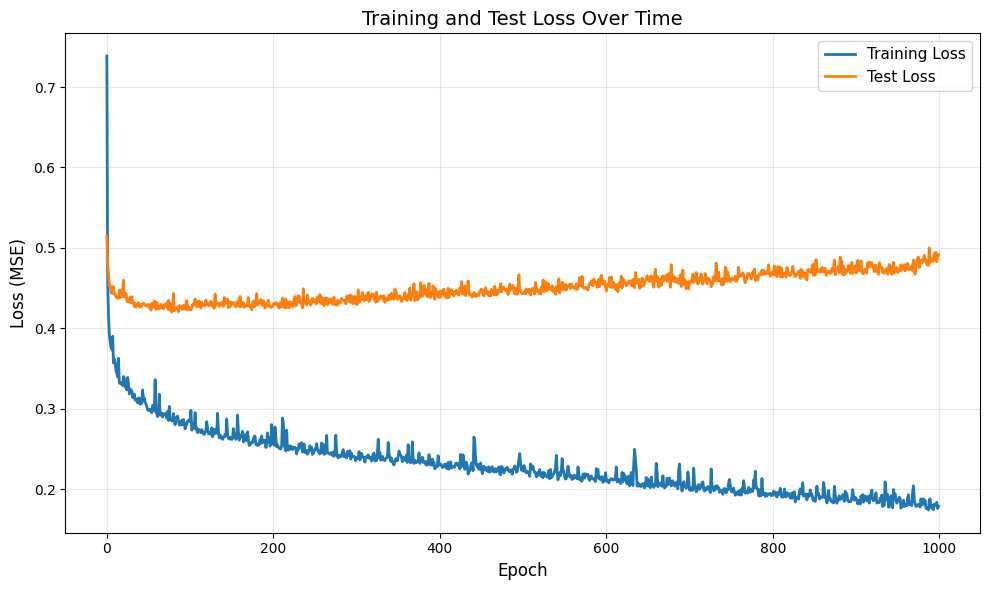

Final Training Loss: 0.1790
Final Test Loss: 0.4916


In [10]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

## 9. Model Evaluation

Evaluate the model on the test set and visualize predictions vs actual values.

In [11]:
# Make predictions
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred_scaled = model(X_test_device).cpu().numpy()

    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = y_test

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

print("Model Performance on Test Set:")
print("=" * 50)
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.0f}")
print("=" * 50)
print(f"Interpretation:")
print(f"Model explains {r2*100:.2f}% of the variance in Car Prices")

Model Performance on Test Set:
R² Score: 0.4384
MAE: 181070
Interpretation:
Model explains 43.84% of the variance in Car Prices


## 10. Visualize Predictions

Compare predicted values with actual values to see how well the model performs.

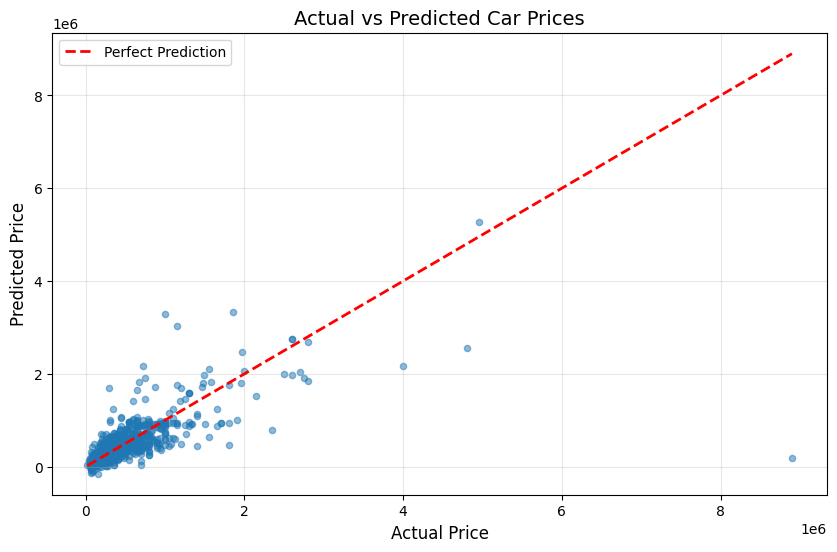


Sample Predictions (first 10 cars):
--------------------------------------------------
      Actual |    Predicted |         Diff
--------------------------------------------------
     165,000 |      145,248 |       19,752
     250,000 |      527,166 |     -277,166
     120,000 |      156,394 |      -36,394
     450,000 |      493,454 |      -43,454
     730,000 |      434,010 |      295,990
     155,000 |      221,436 |      -66,436
     530,000 |      409,749 |      120,251
      92,800 |      132,476 |      -39,676
     284,000 |      531,933 |     -247,933
     260,000 |      316,880 |      -56,880


In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.title('Actual vs Predicted Car Prices', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nSample Predictions (first 10 cars):")
print("-" * 50)
print(f"{'Actual':>12} | {'Predicted':>12} | {'Diff':>12}")
print("-" * 50)
for i in range(min(10, len(y_true))):
    actual = float(y_true[i][0])
    predicted = float(y_pred[i][0])
    diff = actual - predicted
    print(f"{actual:>12,.0f} | {predicted:>12,.0f} | {diff:>12,.0f}")

## 11. Save the Model (Optional)

Save the trained model for future use.

In [13]:
# Save model
torch.save(model.state_dict(), 'car_dekho_model.pth')
print("✓ Model saved to 'car_dekho_model.pth'")

# To load the model later:
# model = RegressionModel(input_size)
# model.load_state_dict(torch.load('house_price_model.pth'))
# model.to(device)
# model.eval()

print("\nTo load this model later, use:")
print("  model = RegressionModel(input_size)")
print("  model.load_state_dict(torch.load('house_price_model.pth'))")
print("  model.to(device)")
print("  model.eval()")

✓ Model saved to 'car_dekho_model.pth'

To load this model later, use:
  model = RegressionModel(input_size)
  model.load_state_dict(torch.load('house_price_model.pth'))
  model.to(device)
  model.eval()


## Summary

### What We Learned:

1. **Data Preparation**: Loaded, split, and normalized data
2. **PyTorch Tensors**: Converted data to PyTorch format
3. **DataLoader**: Created batches for efficient training
4. **Neural Network**: Built a simple feedforward network
5. **Training Loop**: Implemented forward/backward passes
6. **Evaluation**: Assessed model performance with metrics
7. **Visualization**: Plotted training progress and predictions

### Key Concepts:

- **Forward Pass**: Input → Hidden Layers → Output
- **Loss Function**: Measures prediction error (MSE)
- **Backward Pass**: Computes gradients via backpropagation
- **Optimizer**: Updates weights to minimize loss (Adam)
- **Epochs**: Complete passes through training data

### Next Steps:

Try experimenting with:
- Different network architectures (more/fewer layers)
- Different activation functions
- Different optimizers (SGD, RMSprop)
- Learning rate scheduling
- Dropout for regularization

# Homework
1. Kaggle에서 regression 관련 dataset을 찾아 .csv 파일 등등을 다운받고
2. 해당 dataset을 load하여 regression을 통해 최대한 높은 regression 정확도 달성해보기

In [14]:
# 아래 이어서 코드 작성하여 결과를 포함한 .ipynb 파일을 깃허브에 커밋하여 제출하세요!